In [1]:
import numpy as np
import networkx as nx
import matplotlib.pyplot as plt

# Network representation

We first define a class representing a network. It provides the successors of each node as requested by the algorithm. It also allows to draw the network, using the networkx package. 

In [2]:
class network:
    """
    Network representation
    """
    def __init__(self, nodes, arcs, coordinates=None):
        """Constructor
        
        :param nodes: list with the names of the m nodes
        :type nodes: list(str)
        
        :param arcs: a list of tuples (n1, n2, c) where 
                       - n1 is the name of the upstream node
                       - n2 is the name of the downstream node
                       - c is the cost of the arc.
        :type arcs: list(str, str, float)  
        
        :param coordinates: coordinates of the nodes for graphical representation
        :type nodes: list(float, float)
        
        """
        self.nodes = nodes
        self.arcs = arcs
        self.arcCosts = {}
        self.coordinates = coordinates
        
        self.m = len(nodes)
        self.n = len(arcs)
        
        self.successors = [list() for i in range(self.m)] 
        
        self.negativeCosts = False
        self.minCost = None
        
        for n1, n2, c in arcs:
            self.arcCosts[(n1, n2)] = c
            i1 = self.nodeIndex(n1)
            i2 = self.nodeIndex(n2)
            self.successors[i1].append((i2, c))
            if self.minCost is None:
                self.minCost = c
            elif c < self.minCost:
                self.minCost = c
            if c < 0:
                self.negativeCosts = True
                
    def nodeIndex(self, node):
        """
        The nodes are numbered from 0 to m-1. The index is this
        internal number of the node. 
        """
        return self.nodes.index(node)

    def draw(self):
        """
        A simple drawing of the graph based on the networkx package.
        """
        g = nx.DiGraph()
        for n, c in zip(self.nodes, self.coordinates):
            g.add_node(n, pos=c)
        edge_labels = {}
        for n1, n2, c in self.arcs:
            g.add_edge(n1, n2, cost = c)
            edge_labels[(n1, n2)] = f'{c}'
        pos = nx.get_node_attributes(g, 'pos')
        nx.draw(g, pos, with_labels = True, font_weight = 'bold') 
        nx.draw_networkx_edge_labels(g, pos, edge_labels = edge_labels)
        g.clear()

# Dijkstra's algorithm

We now implement Dijkstra's algorithm. In this implementation, we keep in memory the previous node in the path, in order to easily reconstruct the shortest path tree. We use a heap structure to keep the labels of the nodes sorted.

In [3]:
def dijkstra(network, startingNode):
    """
    :param network: the network.
    :type network: class network
    
    :param startingNode: name of the starting node.
    :type startingNode: str
    """
    
    def generateOutput():
        """
        Function preparing the output.
        """
        return {network.nodes[i]: (labels[i], network.nodes[pred[i]]) if pred[i] is not None else (labels[i], None) for i in range(m)}
    
    m = network.m
    n = network.n
    
    # We check if there are negative costs.
    if network.negativeCosts:
        raise Exception("Dijkstra's algortihm requires all costs to be non negative.")
    
    # Initialization of the labels.
    labels = np.array([np.inf for i in range(m)])
    i0 = network.nodeIndex(startingNode)
    labels[i0] = 0

    # Initialization of the predecessors
    pred = [None for i in range(m)]

    # Initialization of the set.
    S = set([i0])

    iterations = []
    while S:
        # Choose the node with the smallest label
        Slist = list(S)
        i = Slist[np.argmin(labels[Slist])]
        iterations.append(f'{[network.nodes[k] for k in S]}\t{network.nodes[i]}\t{labels}')
        S.remove(i)
        # Process all the successors.
        for j, c in network.successors[i]:
            if labels[j] > labels[i] + c:
                labels[j] = labels[i] + c
                S.add(j)
                pred[j] = i
       
    iterations.append(f'{[network.nodes[k] for k in S]}\t{network.nodes[i]}\t{labels}')

    return generateOutput(), iterations

# Network 1

Preparing the network.

In [4]:
nodes = [f'{i}' for i in range(1,10)]
coordinates = [(0, 0), (2, 1.5), (2, -1.5), (4, 1.5), (4, -1.5), (6, 0), (8, 1.5), (10, 0), (8, -1.5)]
arcs = [('1', '2', 8),
        ('1', '3', 14),
        ('2','3', 4),
        ('2','4', 9),
        ('2','5', 7),
        ('3', '5', 11),
        ('4', '5', 12),
        ('4', '6', 17),
        ('5', '6', 3),
        ('5', '9', 8),
        ('6', '7', 5),
        ('6', '8', 9),
        ('7', '8', 3),
        ('9', '8', 9)]

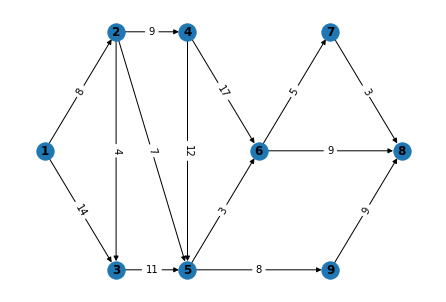

In [5]:
theNetwork = network(nodes, arcs, coordinates)
theNetwork.draw()

Calculating the shortest paths from node '1'.

In [6]:
labels, iterations = dijkstra(theNetwork, '1')

In [7]:
def printLabels(labels):
    for k, v in labels.items():
        print(f'Label of node {k}: {v[0]}. Predecessor in the shortest path: {v[1]}')   

In [8]:
printLabels(labels)

Label of node 1: 0.0. Predecessor in the shortest path: None
Label of node 2: 8.0. Predecessor in the shortest path: 1
Label of node 3: 12.0. Predecessor in the shortest path: 2
Label of node 4: 17.0. Predecessor in the shortest path: 2
Label of node 5: 15.0. Predecessor in the shortest path: 2
Label of node 6: 18.0. Predecessor in the shortest path: 5
Label of node 7: 23.0. Predecessor in the shortest path: 6
Label of node 8: 26.0. Predecessor in the shortest path: 7
Label of node 9: 23.0. Predecessor in the shortest path: 5


In [9]:
for i in iterations:
    print(i)

['1']	1	[ 0. inf inf inf inf inf inf inf inf]
['2', '3']	2	[ 0.  8. 14. inf inf inf inf inf inf]
['3', '4', '5']	3	[ 0.  8. 12. 17. 15. inf inf inf inf]
['4', '5']	5	[ 0.  8. 12. 17. 15. inf inf inf inf]
['4', '6', '9']	4	[ 0.  8. 12. 17. 15. 18. inf inf 23.]
['6', '9']	6	[ 0.  8. 12. 17. 15. 18. inf inf 23.]
['7', '8', '9']	7	[ 0.  8. 12. 17. 15. 18. 23. 27. 23.]
['8', '9']	9	[ 0.  8. 12. 17. 15. 18. 23. 26. 23.]
['8']	8	[ 0.  8. 12. 17. 15. 18. 23. 26. 23.]
[]	8	[ 0.  8. 12. 17. 15. 18. 23. 26. 23.]


Displaying the shortest path tree.

In [10]:
shortestPathArcs = [(v[1], k, theNetwork.arcCosts[(v[1], k)]) for k, v in labels.items() if v[1] is not None]
shortestPathArcs

[('1', '2', 8),
 ('2', '3', 4),
 ('2', '4', 9),
 ('2', '5', 7),
 ('5', '6', 3),
 ('6', '7', 5),
 ('7', '8', 3),
 ('5', '9', 8)]

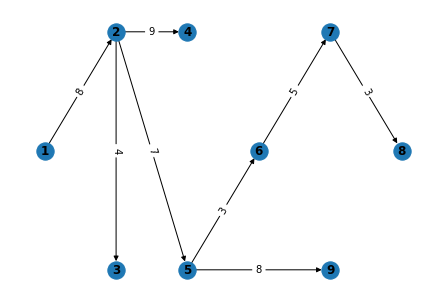

In [11]:
theShortestPathTree = network(nodes, shortestPathArcs, coordinates)
theShortestPathTree.draw()

# Network 2

Preparing the network.

In [12]:
nodes = [f'{i}' for i in range(1,7)]
coordinates = [(0,0), (2,1.5), (2,-1.5), (4,1.5), (4,-1.5), (6,0)]
arcs = [
    ('1', '2', 3),
    ('1', '3', 1),
    ('2', '4', 5),
    ('2', '5', 2.5),
    ('2', '3', 9), 
    ('4', '5', 3),
    ('4', '6', 2),
    ('5', '6', 4),
    ('3', '5', 15)
]

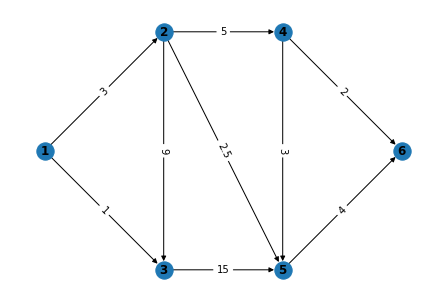

In [13]:
theNetwork = network(nodes, arcs, coordinates)
theNetwork.draw()

Calculating the shortest paths.

In [14]:
labels, iterations = dijkstra(theNetwork, '1')

In [15]:
printLabels(labels)

Label of node 1: 0.0. Predecessor in the shortest path: None
Label of node 2: 3.0. Predecessor in the shortest path: 1
Label of node 3: 1.0. Predecessor in the shortest path: 1
Label of node 4: 8.0. Predecessor in the shortest path: 2
Label of node 5: 5.5. Predecessor in the shortest path: 2
Label of node 6: 9.5. Predecessor in the shortest path: 5


In [16]:
for i in iterations:
    print(i)

['1']	1	[ 0. inf inf inf inf inf]
['2', '3']	3	[ 0.  3.  1. inf inf inf]
['2', '5']	2	[ 0.  3.  1. inf 16. inf]
['4', '5']	5	[0.  3.  1.  8.  5.5 inf]
['4', '6']	4	[0.  3.  1.  8.  5.5 9.5]
['6']	6	[0.  3.  1.  8.  5.5 9.5]
[]	6	[0.  3.  1.  8.  5.5 9.5]


Displaying the shortest path tree.

In [17]:
shortestPathArcs = [(v[1], k, theNetwork.arcCosts[(v[1], k)]) for k, v in labels.items() if v[1] is not None]
shortestPathArcs

[('1', '2', 3), ('1', '3', 1), ('2', '4', 5), ('2', '5', 2.5), ('5', '6', 4)]

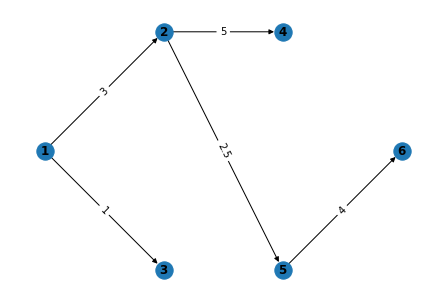

In [18]:
theShortestPathTree = network(nodes, shortestPathArcs, coordinates)
theShortestPathTree.draw()

 # Network 3

Preparing the network.

In [19]:
nodes = [f'{i}' for i in range(1,7)]
coordinates = [(0,0), (2,1.5), (2,-1.5), (4,1.5), (4,-1.5), (6,0)]
arcs = [
    ('1', '2', 5),
    ('1', '3', -3),
    ('2', '4', 4),
    ('2', '5', -2),
    ('3', '2', 9), 
    ('4', '5', 3),
    ('4', '6', 6),
    ('5', '6', -8),
    ('3', '5', 7)
]

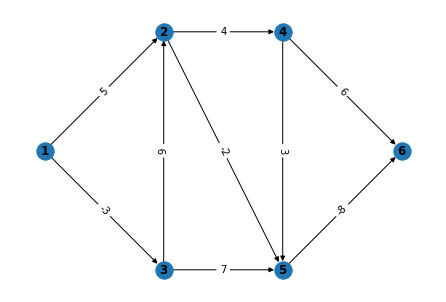

In [20]:
theNetwork = network(nodes, arcs, coordinates)
theNetwork.draw()

Calculating the shortest paths.

In [21]:
labels, iterations = dijkstra(theNetwork, '1')

Exception: Dijkstra's algortihm requires all costs to be non negative.